In [18]:
import random
from queue import PriorityQueue
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [10]:
# Constants

SERVICE = 10.0 # SERVICE is the average service time; service rate = 1/SERVICE
ARRIVAL = 5.0 # ARRIVAL is the average inter-arrival time; arrival rate = 1/ARRIVAL
LOAD=SERVICE/ARRIVAL # This relationship holds for M/M/1
TYPE1 = 1 
SIM_TIME = 100000 # Simulation time
REPEAT = 30 # Number of repetitions for each service rate
CONFIDENCE = 0.95 # Confidence level(95%)
SERVICE_TIMES = [3.0,5.0,7.0] # Different average service times (1/μ)
Service_rates = [1.0 /s for s in SERVICE_TIMES]  #  μ values for the x-axis 
arrivals=0
users=0
BusyServer=False # True: server is currently busy; False: server is currently idle
MM1=[]

In [11]:
# Measurment class

class Measure:
    def __init__(self,Narr,Ndep,NAveraegUser,OldTimeEvent,AverageDelay):
        self.arr = Narr
        self.dep = Ndep
        self.ut = NAveraegUser
        self.oldT = OldTimeEvent
        self.delay = AverageDelay


In [12]:
# Clients 

class Client:
    def __init__(self,type,arrival_time):
        self.type = type
        self.arrival_time = arrival_time

In [13]:
# Server

class Server(object):

    # constructor
    def __init__(self):

        # whether the server is idle or not
        self.idle = True


In [14]:
def arrival(time, FES, queue, SERVICE,ARRIVAL, data):
    global users
    
    #print("Arrival no. ",data.arr+1," at time ",time," with ",users," users" )
    
    # cumulate statistics
    data.arr += 1
    data.ut += users*(time-data.oldT)
    data.oldT = time

    # sample the time until the next event
    inter_arrival = random.expovariate(lambd=1.0/ARRIVAL)
    
    # schedule the next arrival
    FES.put((time + inter_arrival, "arrival"))

    users += 1
    
    # create a record for the client
    client = Client(TYPE1,time)

    # insert the record in the queue
    queue.append(client)

    # if the server is idle start the service
    if users==1:
        
        # sample the service time
        service_time = random.expovariate(1.0/SERVICE)
        #service_time = 1 + random.uniform(0, SEVICE_TIME)

        # schedule when the client will finish the server
        FES.put((time + service_time, "departure"))

In [15]:
def departure(time, FES, queue,SERVICE, data):
    global users

    #print("Departure no. ",data.dep+1," at time ",time," with ",users," users" )
        
    # cumulate statistics
    data.dep += 1
    data.ut += users*(time-data.oldT)
    data.oldT = time
    
    # get the first element from the queue
    client = queue.pop(0)
    
    # do whatever we need to do when clients go away
    
    data.delay += (time-client.arrival_time)
    users -= 1
    
    # see whether there are more clients to in the line
    if users >0:
        # sample the service time
        service_time = random.expovariate(1.0/SERVICE)

        # schedule when the client will finish the server
        FES.put((time + service_time, "departure"))

        

In [16]:
# Simulation Function
def run_simulation(SERVICE, ARRIVAL, SIM_TIME):
    global users
    users = 0
    queue = []
    data = Measure(0, 0, 0, 0, 0)

    FES = PriorityQueue()
    FES.put((0, "arrival"))
    time = 0

    while time < SIM_TIME:
        (time, event_type) = FES.get()
        if event_type == "arrival":
            arrival(time, FES, queue, SERVICE, ARRIVAL, data)
        elif event_type == "departure":
            departure(time, FES, queue, SERVICE, data)

    avg_delay = data.delay / data.dep if data.dep > 0 else 0
    return avg_delay


In [19]:
# Run Simulation for each service time and compute confidemce intervals
mean_delays = []
ci_lowers = []
ci_uppers = []

for service_time in SERVICE_TIMES:
    delays = [run_simulation(service_time, ARRIVAL, SIM_TIME) for _ in range(REPEAT)]
    mean = np.mean(delays)
    std = np.std(delays, ddof=1)
    z = stats.norm.ppf(1 - (1 - CONFIDENCE) / 2)
    margin = z * std / np.sqrt(REPEAT)

    mean_delays.append(mean)
    ci_lowers.append(mean - margin)
    ci_uppers.append(mean + margin)

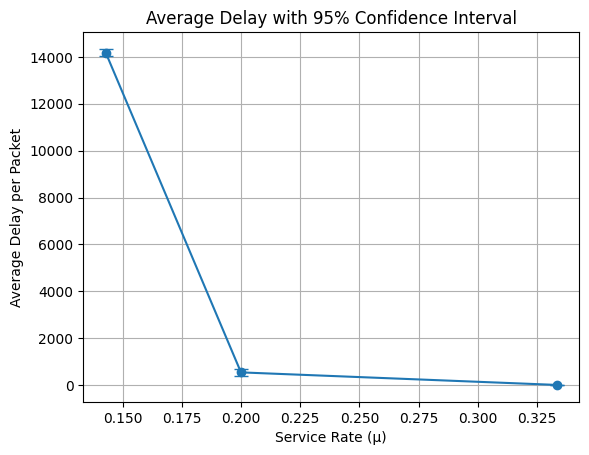

In [21]:
# plot : Average Dely with confidence intervals
mus = [1/s for s in SERVICE_TIMES]  # μ values
errors = [mean - low for mean, low in zip(mean_delays, ci_lowers)]

plt.figure()
plt.errorbar(mus, mean_delays, yerr=errors, fmt='o-', capsize=5)
plt.xlabel("Service Rate (μ)")
plt.ylabel("Average Delay per Packet")
plt.title("Average Delay with 95% Confidence Interval")
plt.grid(True)
plt.show()
